In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [2]:
# display 확장
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

# train, valid, test file 경로 지정
file = './physionet2012_train.csv'
file2 = './physionet2012_valid.csv'
file3 = './physionet2012_test.csv'

# train data 로딩
df = pd.read_csv(file, index_col=None)
del df['Unnamed: 0']
df.head()

# valid data 로딩
valid_df = pd.read_csv(file2, index_col=None)
del valid_df['Unnamed: 0']
valid_df.head()

# tess data 로딩
test_df = pd.read_csv(file3, index_col=None)
del test_df['Unnamed: 0']
test_df.head()

,pid,rec_time,age,Gender,ICUType,ALP,ALT,AST,Albumin,BUN,Bilirubin,Cholesterol,Creatinine,FiO2,GCS,Glucose,HCO3,HCT,HR,K,Lactate,Mg,Na,PaCO2,PaO2,Platelets,RR,SPO2,BT,Tropl,TroponinI,TropT,TroponinT,Urine,WBC,pH,MechVent,survival,SBP,DBP,MBP,male,female,surv_los
0,135089,0:00:00,90.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,97.0,37.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,116.0,58.0,77.0,1,0,-7
1,135089,0:44:00,90.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.0,NaN,2.9,NaN,NaN,NaN,NaN,NaN,19.0,97.0,37.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,116.0,58.0,77.0,1,0,-7
2,135089,2:09:00,90.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,97.0,38.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,116.0,58.0,77.0,1,0,-7
3,135089,2:10:00,90.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,97.0,38.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,116.0,58.0,77.0,1,0,-7
4,135089,2:15:00,90.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,97.0,38.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,116.0,58.0,77.0,1,0,-7


In [3]:
# 데이터 수와 환자 수 파악
print('총 데이터 수: {}'.format(len(df)))
print('총 환자 수: {}'.format(len(df.pid.unique())))

print('총 데이터 수: {}'.format(len(valid_df)))
print('총 환자 수: {}'.format(len(valid_df.pid.unique())))

print('총 데이터 수: {}'.format(len(test_df)))
print('총 환자 수: {}'.format(len(test_df.pid.unique())))


총 데이터 수: 242613
총 환자 수: 3240
총 데이터 수: 27097
총 환자 수: 360
총 데이터 수: 29554
총 환자 수: 400


In [4]:
# dtype 파악
df.dtypes.value_counts()

float64    38
int64       6
object      1
dtype: int64

In [5]:
# null_ratio = 0.5
# over_05 = df.notnull().sum()[(df.notnull().sum() / len(df)) > null_ratio].map(lambda x: x / len(df))

# print(f"결측치 비율이 0.5 이상인 컬럼 수: {len(over_05)}")
# over_05
# over_columns = over_05.index
# print(over_columns)

# df2 = df[over_columns]
# df2.head()

## 1. 생존 유무 라벨링(0: survival, 1:death)
- Survival > Length of stay  ⇒  Survivor
- Survival = -1  ⇒  Survivor
- 2 ≤ Survival ≤ Length of stay  ⇒  In-hospital death

- surv-los > 0 => 0
- Survival = -1 => 0
- surv-los <= 0 => 1


In [4]:
import numpy as np

# train 데이터 생존 유무 라벨링
labels = np.zeros(len(df))
labels[df[(2 <= df.survival) & (df.surv_los <= 0)].index.to_list()] = 1
labels[df[df.surv_los > 0].index.to_list()] = 0
labels[df[df.survival == -1].index.to_list()] = 0
df['labels'] = labels

cnt = df[['pid', 'labels']].drop_duplicates(['pid'])['labels'].value_counts()
print(f'num of survival: {cnt.iloc[0]} \n num of death: {cnt.iloc[1]}')

# valid data 생존 유무 라벨링
valid_labels = np.zeros(len(valid_df))
valid_labels[valid_df[(2 <= valid_df.survival) & (valid_df.surv_los <= 0)].index.to_list()] = 1
valid_labels[valid_df[valid_df.surv_los > 0].index.to_list()] = 0
valid_labels[valid_df[valid_df.survival == -1].index.to_list()] = 0
valid_df['labels'] = valid_labels

cnt = valid_df[['pid', 'labels']].drop_duplicates(['pid'])['labels'].value_counts()
print(f'num of survival: {cnt.iloc[0]} \n num of death: {cnt.iloc[1]}')

# test data 생존 유무 라벨링
test_labels = np.zeros(len(test_df))
test_labels[test_df[(2 <= test_df.survival) & (test_df.surv_los <= 0)].index.to_list()] = 1
test_labels[test_df[test_df.surv_los > 0].index.to_list()] = 0
test_labels[test_df[test_df.survival == -1].index.to_list()] = 0
test_df['labels'] = test_labels

cnt = test_df[['pid', 'labels']].drop_duplicates(['pid'])['labels'].value_counts()
print(f'num of survival: {cnt.iloc[0]} \n num of death: {cnt.iloc[1]}')

num of survival: 2813 
 num of death: 427
num of survival: 311 
 num of death: 49
num of survival: 348 
 num of death: 52


## 데이터 전처리 - 결측치 채우기
 - 1. fillna(method='ffill')
 - 2. fillna(컬럼별 median)
 - 3. 의문점1) 결측치 비율이 0.5가 넘는 컬럼도 무리하게 결측치를 채워 사용해도 되는가?
 - 4. 의문점2) method='ffill'을 사용하면 다른 pid의 컬럼 내용을 가져올 리는 없는가?

### 

- 제일 첫 값이 nun -> median
- 그 다음에 fillna(ffill)
- fillna(bfill)은 쓰면 안됨!!

In [5]:
first_index = df.drop_duplicates('pid').index
first_indext = test_df.drop_duplicates('pid').index
first_indexv= valid_df.drop_duplicates('pid').index

colss=df.columns
cols=[]
for i in range (2,colss.size):
    cols.append(colss[i])
# 중앙값 구하기
median_dict={}
stat_dict = {}
for col in cols:
    median_dict[col] = df[col].median()
    stat_dict[col] = {'mean': df[col].mean(), 'std': df[col].std()}

In [6]:
import pickle

In [7]:
with open('median_dict.pkl', 'wb') as f:
    pickle.dump(median_dict, f)

In [8]:
median_dict

{'age': 67.0,
 'Gender': 1.0,
 'ICUType': 3.0,
 'ALP': 82.0,
 'ALT': 43.0,
 'AST': 63.0,
 'Albumin': 2.9,
 'BUN': 20.0,
 'Bilirubin': 0.9,
 'Cholesterol': 154.0,
 'Creatinine': 1.0,
 'FiO2': 0.5,
 'GCS': 13.0,
 'Glucose': 127.0,
 'HCO3': 23.0,
 'HCT': 30.3,
 'HR': 86.0,
 'K': 4.1,
 'Lactate': 2.1,
 'Mg': 2.0,
 'Na': 139.0,
 'PaCO2': 39.0,
 'PaO2': 122.0,
 'Platelets': 173.0,
 'RR': 19.0,
 'SPO2': 97.0,
 'BT': 37.1,
 'Tropl': nan,
 'TroponinI': 2.9,
 'TropT': nan,
 'TroponinT': 0.22,
 'Urine': 70.0,
 'WBC': 11.5,
 'pH': 7.38,
 'MechVent': 1.0,
 'survival': -1.0,
 'SBP': 116.0,
 'DBP': 58.0,
 'MBP': 77.0,
 'male': 1.0,
 'female': 0.0,
 'surv_los': -7.0,
 'labels': 0.0}

In [9]:
# 결측치 채우기 
df3 = df.copy()
# train 데이터
for col in cols:
  # 첫번째 인덱스가 0이 아닌경우 먼저 중앙값으로 결측치 채우기
    for i in first_index:
        if np.isnan(df3.loc[i,col])==True:
            df3.loc[i, col] = median_dict[col]
 # 환자별 컬럼별로 만약 np.nan이 존재한다면, 이전 데이터의 값을 가지고 채운다. method='ffill
    df3[col] =df3[col].fillna(method='ffill')

valid_df3 = valid_df.copy()
# valid 데이터
for col in cols:
    for i in first_indexv:
        if np.isnan(valid_df3.loc[i,col])==True:
            valid_df3.loc[i, col] = median_dict[col]
    valid_df3[col] = valid_df3[col].fillna(method='ffill')

test_df3 = test_df.copy()
# test 데이터
for col in cols:
    for i in first_indext:
        if np.isnan(test_df3.loc[i,col])==True:
            test_df3.loc[i, col] = median_dict[col]
    test_df3[col] = test_df3[col].fillna(method='ffill')

In [10]:
# 데이터 개수와 컬럼별 null 개수 확인
print(len(df3))
pd.DataFrame(df3.isnull().sum())

print(len(valid_df3))
pd.DataFrame(valid_df3.isnull().sum())

print(len(test_df3))
pd.DataFrame(test_df3.isnull().sum())

242613
27097
29554


,0
pid,0
rec_time,0
age,0
Gender,0
ICUType,0
ALP,0
ALT,0
AST,0
Albumin,0
BUN,0


In [11]:
# 데이터가 단 하나도 없는 column 'Tropl', 'TropT' 제외
# 'rec_time'은 이후 padding에서 np.zeros에 string 데이터가 들어갈 수 없는 문제를 해결하기 위해 미리 제거
df4 = df3.drop(columns=['Tropl', 'TropT', 'rec_time'])
pd.DataFrame(df4.isnull().sum())

valid_df4 = valid_df3.drop(columns=['Tropl', 'TropT', 'rec_time'])
pd.DataFrame(valid_df4.isnull().sum())

test_df4 = test_df3.drop(columns=['Tropl', 'TropT', 'rec_time'])
pd.DataFrame(test_df4.isnull().sum())

,0
pid,0
age,0
Gender,0
ICUType,0
ALP,0
ALT,0
AST,0
Albumin,0
BUN,0
Bilirubin,0


In [11]:
test_df4.head()

,pid,age,Gender,ICUType,ALP,ALT,AST,Albumin,BUN,Bilirubin,Cholesterol,Creatinine,FiO2,GCS,Glucose,HCO3,HCT,HR,K,Lactate,Mg,Na,PaCO2,PaO2,Platelets,RR,SPO2,BT,TroponinI,TroponinT,Urine,WBC,pH,MechVent,survival,SBP,DBP,MBP,male,female,surv_los,LOS,labels
0,135089,90.0,1.0,3.0,82.0,43.0,63.0,2.9,20.0,0.9,154.0,1.0,0.5,13.0,127.0,23.0,30.3,86.0,4.1,2.1,2.0,139.0,39.0,122.0,173.0,19.0,97.0,37.1,2.9,0.22,70.0,11.5,7.38,1.0,-1,116.0,58.0,77.0,1,0,-7,6,0.0
1,135089,90.0,1.0,3.0,82.0,43.0,63.0,2.9,20.0,0.9,154.0,1.0,0.5,13.0,127.0,23.0,30.3,86.0,4.1,2.9,2.0,139.0,39.0,122.0,173.0,19.0,97.0,37.1,2.9,0.22,70.0,11.5,7.38,1.0,-1,116.0,58.0,77.0,1,0,-7,6,0.0
2,135089,90.0,1.0,3.0,82.0,43.0,63.0,2.9,20.0,0.9,154.0,1.0,0.5,13.0,127.0,23.0,30.3,130.0,4.1,2.9,2.0,139.0,39.0,122.0,173.0,28.0,97.0,38.7,2.9,0.22,70.0,11.5,7.38,1.0,-1,116.0,58.0,77.0,1,0,-7,6,0.0
3,135089,90.0,1.0,3.0,82.0,43.0,63.0,2.9,20.0,0.9,154.0,1.0,0.5,13.0,127.0,23.0,30.3,130.0,4.1,2.9,2.0,139.0,39.0,122.0,173.0,22.0,97.0,38.7,2.9,0.22,70.0,11.5,7.38,1.0,-1,116.0,58.0,77.0,1,0,-7,6,0.0
4,135089,90.0,1.0,3.0,82.0,43.0,63.0,2.9,20.0,0.9,154.0,1.0,0.5,13.0,127.0,23.0,30.3,123.0,4.1,2.9,2.0,139.0,39.0,122.0,173.0,23.0,97.0,38.7,2.9,0.22,70.0,11.5,7.38,1.0,-1,116.0,58.0,77.0,1,0,-7,6,0.0


## 3. zero-padding
- maxlen 보다 적은 수의 데이터를 가진 환자들은 zero-padding으로 데이터를 채워넣는다.
- maxlen 보다 큰 수의 데이터는 maxlen 크기만큼 데이터를 자른다.
- maxlen = 70
- pre-zero-padding
- np.zeros에 string이 들어갈 수 없기 때문에 rec_time column을 제외시키자.(앞선 코드에서 적용함.)
- 여전히 남은 의문점: 측정되지 않았다고 모든 컬럼에 0.0을 넣어도 될까? 실제 그 수치가 아닐 수도 있는데? 모르는 것과 없는 것은 다를텐데 이를 어떻게 이해해야 할지.

In [12]:

maxlen = 70
# zero-padding 함수
def zero_padding(dataframe, maxlen):
    maxlen = maxlen
    df4 = dataframe
    col_len = len(df4.columns)
    data = []
    # 기본정보는 zero_padding에 모두 동일하게 적용되어야 함으로 따로 취급한다. 나머지는 모두 0.0으로 채운다.
    basic_col = 'pid, age, Gender, ICUType, survival, male, female, surv_los, labels'
    basic_col_list = basic_col.split(', ')
    basic_col_indexer = df4.columns.get_indexer(basic_col_list)
    basic_col_indexer

    for pid in df4.pid.drop_duplicates().to_numpy():
        if len(df4[df4.pid == pid]) >= maxlen:
            dummy = df4[df4.pid == pid].to_numpy().tolist()
            data.append(dummy[:maxlen])
        else:
            length = len(df4[df4.pid == pid])
            base = np.zeros((maxlen, col_len))
            for idx in basic_col_indexer:
                base[:, idx] = df4[df4.pid == pid].iloc[0, idx]
            # print(base.shape)
            dummy = df4[df4.pid == pid].to_numpy()
            # print(dummy.shape)
            base[-length:] = dummy
            # print(base.shape)
            # base[:length, 0] = pid
            # base[:length, -1] = dummy[0, -1] 
            data.append(base.tolist())
    return data

data = zero_padding(df4, maxlen)
valid_data = zero_padding(valid_df4, maxlen)
test_data = zero_padding(test_df4, maxlen)


In [13]:
# zero_padding 결과는 list 형식의 3차원 데이터(참고로 리스트에는 차원이 없지만 쉬운 이해를 위해 차원이라 함.)
# train 데이터 결과를 dataframe으로 변환
data = np.array(data)
data = data.reshape((-1, len(df4.columns)))
df5 = pd.DataFrame(data, columns=df4.columns)
# train data 환자 수: 3240
print(3240* 70, len(df5))
df5

valid_data = np.array(valid_data)
valid_data = valid_data.reshape((-1, len(valid_df4.columns)))
valid_df5 = pd.DataFrame(valid_data, columns=valid_df4.columns)
# valid data 환자 수: 360
print(360* 70, len(valid_df5))
valid_df5

test_data = np.array(test_data)
test_data = test_data.reshape((-1, len(test_df4.columns)))
test_df5 = pd.DataFrame(test_data, columns=df4.columns)
# test
# data 환자 수: 400
print(400* 70, len(test_df5))
test_df5

226800 226800
25200 25200
28000 28000


,pid,age,Gender,ICUType,ALP,ALT,AST,Albumin,BUN,Bilirubin,Cholesterol,Creatinine,FiO2,GCS,Glucose,HCO3,HCT,HR,K,Lactate,Mg,Na,PaCO2,PaO2,Platelets,RR,SPO2,BT,TroponinI,TroponinT,Urine,WBC,pH,MechVent,survival,SBP,DBP,MBP,male,female,surv_los,labels
0,135089.0,90.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,-1.0,0.0,0.0,0.0,1.0,0.0,-7.0,0.0
1,135089.0,90.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,-1.0,0.0,0.0,0.0,1.0,0.0,-7.0,0.0
2,135089.0,90.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,-1.0,0.0,0.0,0.0,1.0,0.0,-7.0,0.0
3,135089.0,90.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,-1.0,0.0,0.0,0.0,1.0,0.0,-7.0,0.0
4,135089.0,90.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,-1.0,0.0,0.0,0.0,1.0,0.0,-7.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,135219.0,78.0,0.0,4.0,82.0,43.0,63.0,2.9,14.0,0.9,154.0,1.4,0.5,15.0,117.0,22.0,30.4,59.0,4.3,2.1,1.8,131.0,40.0,122.0,144.0,22.0,98.0,37.6,2.9,0.22,35.0,11.9,7.35,1.0,2011.0,134.0,51.0,79.0,1.0,0.0,2002.0,0.0
27996,135219.0,78.0,0.0,4.0,82.0,43.0,63.0,2.9,14.0,0.9,154.0,1.4,0.5,15.0,117.0,22.0,30.4,60.0,4.3,2.1,1.8,131.0,40.0,122.0,144.0,22.0,98.0,37.6,2.9,0.22,35.0,11.9,7.35,1.0,2011.0,132.0,50.0,78.0,1.0,0.0,2002.0,0.0
27997,135219.0,78.0,0.0,4.0,82.0,43.0,63.0,2.9,14.0,0.9,154.0,1.4,0.5,15.0,117.0,22.0,30.4,66.0,4.3,2.1,1.8,131.0,40.0,122.0,144.0,18.0,98.0,37.7,2.9,0.22,45.0,11.9,7.35,1.0,2011.0,139.0,54.0,84.0,1.0,0.0,2002.0,0.0
27998,135219.0,78.0,0.0,4.0,82.0,43.0,63.0,2.9,14.0,0.9,154.0,1.4,0.5,15.0,117.0,22.0,30.4,66.0,4.3,2.1,1.8,131.0,40.0,90.0,144.0,18.0,98.0,37.7,2.9,0.22,45.0,11.9,7.37,1.0,2011.0,139.0,54.0,84.0,1.0,0.0,2002.0,0.0


In [14]:
# train 데이터의 생존자 수와 사망자 수 확인
df5.shape
df5.pid.value_counts()
df5[['pid', 'labels']].drop_duplicates(['pid'])['labels'].value_counts()

valid_df5.shape
valid_df5.pid.value_counts()
valid_df5[['pid', 'labels']].drop_duplicates(['pid'])['labels'].value_counts()

test_df5.shape
test_df5.pid.value_counts()
test_df5[['pid', 'labels']].drop_duplicates(['pid'])['labels'].value_counts()

0.0    348
1.0     52
Name: labels, dtype: int64

## 4. Normalization
- 기본 정보, categorical(숫자로 되어 있지만 명목 변수)은 정규화 대상에서 제외
- minmax scaler를 활용함.

In [15]:
df5.columns

Index(['pid', 'age', 'Gender', 'ICUType', 'ALP', 'ALT', 'AST', 'Albumin',
       'BUN', 'Bilirubin', 'Cholesterol', 'Creatinine', 'FiO2', 'GCS',
       'Glucose', 'HCO3', 'HCT', 'HR', 'K', 'Lactate', 'Mg', 'Na', 'PaCO2',
       'PaO2', 'Platelets', 'RR', 'SPO2', 'BT', 'TroponinI', 'TroponinT',
       'Urine', 'WBC', 'pH', 'MechVent', 'survival', 'SBP', 'DBP', 'MBP',
       'male', 'female', 'surv_los', 'labels'],
      dtype='object')

In [16]:
#!pip install scikit-learn

In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [17]:
df5_1= df5.drop(columns=['pid','age','Gender','ICUType' , 'male', 'female','survival', 'surv_los', 'labels'])
test_df5_1 = test_df5.drop(columns=['pid','age','Gender','ICUType' , 'male', 'female','survival', 'surv_los', 'labels'])
valid_df5_1 = valid_df5.drop(columns=['pid','age','Gender','ICUType' , 'male', 'female','survival', 'surv_los', 'labels'])

scale = MinMaxScaler()
scale.fit(df5_1)
df5_2 = scale.transform(df5_1)
test_df5_2 = scale.transform(test_df5_1)
valid_df5_2 = scale.transform(valid_df5_1)

column_names = df5_1.columns
df5_2 = pd.DataFrame(df5_2, columns=column_names)
test_df5_2 = pd.DataFrame(test_df5_2, columns=column_names)
valid_df5_2 = pd.DataFrame(valid_df5_2, columns=column_names)

df5_2.insert(0, 'pid', df5['pid'])
df5_2.insert(1, 'age', df5['age'])
df5_2.insert(2, 'Gender', df5['Gender'])
df5_2.insert(3, 'ICUType', df5['ICUType'])
df5_2['male'] = df5['male']
df5_2['female'] = df5['female']
df5_2['survival'] = df5['survival']
df5_2['surv_los'] = df5['surv_los']
df5_2['labels'] = df5['labels']

test_df5_2.insert(0, 'pid', test_df5['pid'])
test_df5_2.insert(1, 'age', test_df5['age'])
test_df5_2.insert(2, 'Gender', test_df5['Gender'])
test_df5_2.insert(3, 'ICUType', test_df5['ICUType'])
test_df5_2['male'] = test_df5['male']
test_df5_2['female'] = test_df5['female']
test_df5_2['survival'] = test_df5['survival']
test_df5_2['surv_los'] = test_df5['surv_los']
test_df5_2['labels'] = test_df5['labels']

valid_df5_2.insert(0, 'pid', valid_df5['pid'])
valid_df5_2.insert(1, 'age', valid_df5['age'])
valid_df5_2.insert(2, 'Gender', valid_df5['Gender'])
valid_df5_2.insert(3, 'ICUType', valid_df5['ICUType'])
valid_df5_2['male'] = valid_df5['male']
valid_df5_2['female'] = valid_df5['female']
valid_df5_2['survival'] = valid_df5['survival']
valid_df5_2['surv_los'] = valid_df5['surv_los']
valid_df5_2['labels'] = valid_df5['labels']

In [18]:
with open(file='minmax.pickle', mode='wb') as f:
    pickle.dump(scale.fit(df5_1), f)

In [19]:
df5 = df5_2
test_df5 = test_df5_2
valid_df5 = valid_df5_2

In [20]:
df5.head()

,pid,age,Gender,ICUType,ALP,ALT,AST,Albumin,BUN,Bilirubin,Cholesterol,Creatinine,FiO2,GCS,Glucose,HCO3,HCT,HR,K,Lactate,Mg,Na,PaCO2,PaO2,Platelets,RR,SPO2,BT,TroponinI,TroponinT,Urine,WBC,pH,MechVent,SBP,DBP,MBP,male,female,survival,surv_los,labels
0,142219.0,52.0,0.0,3.0,0.046804,0.003749,0.003928,0.58,0.101523,0.018868,0.466667,0.045249,0.5,0.866667,0.111111,0.46,0.490291,0.286667,0.179039,0.071672,0.25974,0.785311,0.39,0.244,0.165234,0.487179,0.97,0.916528,0.058943,0.008832,0.006364,0.061333,0.010041,1.0,0.393220,0.216418,0.256667,1.0,0.0,-1.0,-8.0,0.0
1,142219.0,52.0,0.0,3.0,0.046804,0.003749,0.003928,0.58,0.101523,0.018868,0.466667,0.045249,0.8,0.866667,0.111111,0.46,0.490291,0.343333,0.179039,0.071672,0.25974,0.785311,0.39,0.244,0.165234,0.487179,0.97,0.916528,0.058943,0.008832,0.045455,0.061333,0.010041,1.0,0.393220,0.216418,0.256667,1.0,0.0,-1.0,-8.0,0.0
2,142219.0,52.0,0.0,3.0,0.046804,0.003749,0.003928,0.58,0.101523,0.018868,0.466667,0.045249,0.8,0.866667,0.111111,0.46,0.490291,0.333333,0.179039,0.071672,0.25974,0.785311,0.39,0.244,0.165234,0.487179,0.97,0.916528,0.058943,0.008832,0.045455,0.061333,0.010041,1.0,0.000000,0.000000,0.746667,1.0,0.0,-1.0,-8.0,0.0
3,142219.0,52.0,0.0,3.0,0.046804,0.003749,0.003928,0.58,0.101523,0.018868,0.466667,0.045249,0.8,0.866667,0.111111,0.46,0.490291,0.353333,0.179039,0.071672,0.25974,0.785311,0.39,0.244,0.165234,0.487179,0.97,0.916528,0.058943,0.008832,0.045455,0.061333,0.010041,1.0,0.000000,0.000000,0.450000,1.0,0.0,-1.0,-8.0,0.0
4,142219.0,52.0,0.0,3.0,0.046804,0.003749,0.003928,0.58,0.101523,0.018868,0.466667,0.045249,0.8,0.866667,0.111111,0.46,0.490291,0.350000,0.179039,0.071672,0.25974,0.785311,0.39,0.244,0.165234,0.487179,0.97,0.916528,0.058943,0.008832,0.040909,0.061333,0.010041,1.0,0.735593,0.402985,0.443333,1.0,0.0,-1.0,-8.0,0.0


<AxesSubplot:>

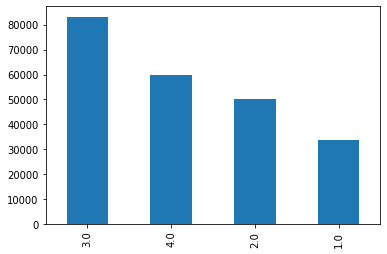

In [21]:
import matplotlib.pyplot as plt

bins = [i for i in range(1, 100, 5)]
cats = pd.cut(df5.age, bins, labels=bins[:-1])
cats.value_counts().plot.bar()

icu_type = {1.: '관상동맥치료실', 2.: '심장수술회복실', 3.: '의료ICU', 4.: '외과ICU'}
df5.ICUType.value_counts().plot.bar()

In [22]:
# # Gender 중에 -1 값을 갖는 pid가 3개 있음.
# print(df5[df5.Gender == -1.]['pid'].unique())

# # 확인 결과 Gender {1:'male', 0:'female'}
# print(df5[df5.Gender == 1]['male'])

# # 확인 결과, Gender==-1은 male 인 것으로 판단되어 -1을 1로 치환함. 
# print(df5.Gender.value_counts())
# # print(pd.DataFrame(df5[df5.Gender == -1]['female']))
# print(pd.DataFrame(df5[df5.Gender == -1]['male']))

df5.Gender.replace({-1.:1.0}, inplace=True)
df5.Gender.value_counts()

1.0    127470
0.0     99330
Name: Gender, dtype: int64

In [23]:
df5

,pid,age,Gender,ICUType,ALP,ALT,AST,Albumin,BUN,Bilirubin,Cholesterol,Creatinine,FiO2,GCS,Glucose,HCO3,HCT,HR,K,Lactate,Mg,Na,PaCO2,PaO2,Platelets,RR,SPO2,BT,TroponinI,TroponinT,Urine,WBC,pH,MechVent,SBP,DBP,MBP,LOS,male,female,survival,surv_los,labels
0,142219.0,52.0,0.0,3.0,0.046804,0.003749,0.003928,0.58,0.101523,0.018868,0.466667,0.045249,0.5,0.866667,0.111111,0.46,0.490291,0.286667,0.179039,0.071672,0.25974,0.785311,0.39,0.244,0.165234,0.487179,0.97,0.916528,0.058943,0.008832,0.006364,0.061333,0.010041,1.0,0.393220,0.216418,0.256667,0.051613,1.0,0.0,-1.0,-8.0,0.0
1,142219.0,52.0,0.0,3.0,0.046804,0.003749,0.003928,0.58,0.101523,0.018868,0.466667,0.045249,0.8,0.866667,0.111111,0.46,0.490291,0.343333,0.179039,0.071672,0.25974,0.785311,0.39,0.244,0.165234,0.487179,0.97,0.916528,0.058943,0.008832,0.045455,0.061333,0.010041,1.0,0.393220,0.216418,0.256667,0.051613,1.0,0.0,-1.0,-8.0,0.0
2,142219.0,52.0,0.0,3.0,0.046804,0.003749,0.003928,0.58,0.101523,0.018868,0.466667,0.045249,0.8,0.866667,0.111111,0.46,0.490291,0.333333,0.179039,0.071672,0.25974,0.785311,0.39,0.244,0.165234,0.487179,0.97,0.916528,0.058943,0.008832,0.045455,0.061333,0.010041,1.0,0.000000,0.000000,0.746667,0.051613,1.0,0.0,-1.0,-8.0,0.0
3,142219.0,52.0,0.0,3.0,0.046804,0.003749,0.003928,0.58,0.101523,0.018868,0.466667,0.045249,0.8,0.866667,0.111111,0.46,0.490291,0.353333,0.179039,0.071672,0.25974,0.785311,0.39,0.244,0.165234,0.487179,0.97,0.916528,0.058943,0.008832,0.045455,0.061333,0.010041,1.0,0.000000,0.000000,0.450000,0.051613,1.0,0.0,-1.0,-8.0,0.0
4,142219.0,52.0,0.0,3.0,0.046804,0.003749,0.003928,0.58,0.101523,0.018868,0.466667,0.045249,0.8,0.866667,0.111111,0.46,0.490291,0.350000,0.179039,0.071672,0.25974,0.785311,0.39,0.244,0.165234,0.487179,0.97,0.916528,0.058943,0.008832,0.040909,0.061333,0.010041,1.0,0.735593,0.402985,0.443333,0.051613,1.0,0.0,-1.0,-8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226795,138581.0,53.0,1.0,4.0,0.046804,0.003749,0.003928,0.58,0.091371,0.018868,0.466667,0.049774,0.4,0.533333,0.138233,0.50,0.378641,0.310000,0.161572,0.034130,0.25974,0.757062,0.42,0.394,0.169054,0.487179,1.00,0.918197,0.058943,0.008832,0.003818,0.068800,0.010095,1.0,0.400000,0.246269,0.283333,0.122581,1.0,0.0,17.0,-1.0,1.0
226796,138581.0,53.0,1.0,4.0,0.046804,0.003749,0.003928,0.58,0.091371,0.018868,0.466667,0.049774,0.4,0.533333,0.138233,0.50,0.378641,0.313333,0.161572,0.034130,0.25974,0.757062,0.42,0.394,0.169054,0.487179,1.00,0.918197,0.058943,0.008832,0.010000,0.068800,0.010095,1.0,0.437288,0.264925,0.310000,0.122581,1.0,0.0,17.0,-1.0,1.0
226797,138581.0,53.0,1.0,4.0,0.046804,0.003749,0.003928,0.58,0.091371,0.018868,0.466667,0.049774,0.4,0.533333,0.138233,0.50,0.378641,0.283333,0.161572,0.034130,0.25974,0.757062,0.42,0.394,0.169054,0.487179,1.00,0.913189,0.058943,0.008832,0.007273,0.068800,0.010095,1.0,0.386441,0.242537,0.280000,0.122581,1.0,0.0,17.0,-1.0,1.0
226798,138581.0,53.0,1.0,4.0,0.046804,0.003749,0.003928,0.58,0.091371,0.018868,0.466667,0.049774,0.4,0.533333,0.138233,0.50,0.378641,0.276667,0.161572,0.034130,0.25974,0.757062,0.42,0.394,0.169054,0.487179,1.00,0.913189,0.058943,0.008832,0.003636,0.068800,0.010095,1.0,0.376271,0.227612,0.266667,0.122581,1.0,0.0,17.0,-1.0,1.0


In [24]:
# 'ICUType' 원-핫 인코딩
df6 = pd.get_dummies(df5, columns=['ICUType'])
print(len(df5.columns))
print(len(df6.columns))
print('ICUType' in df6.columns)

valid_df6 = pd.get_dummies(valid_df5, columns=['ICUType'])
# print(len(valid_df5.columns))
# print(len(valid_df6.columns))
# print('ICUType' in valid_df6.columns)

test_df6 = pd.get_dummies(test_df5, columns=['ICUType'])
# print(len(test_df5.columns))
# print(len(test_df6.columns))
# print('ICUType' in test_df6.columns)

43
46
False


In [25]:
X_train = []
y_train = []
for pid in tqdm(df6.pid.unique()):
    pid_df = df6.query('pid==@pid')
    pid_x = pid_df.drop(columns=['pid', 'Gender', 'survival', 'surv_los', 'labels', 'LOS'])
    pid_y = pid_df['labels']
    pid_x = pid_x.astype(float)
    X_train.append(pid_x)
    y_train.append(pid_y)
    

  0%|          | 0/3240 [00:00<?, ?it/s]

In [26]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [27]:
X_valid = []
y_valid = []
for pid in tqdm(valid_df6.pid.unique()):
    pid_df = valid_df6.query('pid==@pid')
    pid_x = pid_df.drop(columns=['pid', 'Gender', 'survival', 'surv_los', 'labels', 'LOS'])
    pid_y = pid_df['labels']
    pid_x = pid_x.astype(float)
    X_valid.append(pid_x)
    y_valid.append(pid_y)
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)    

  0%|          | 0/360 [00:00<?, ?it/s]

In [28]:
X_test = []
y_test = []
for pid in tqdm(test_df6.pid.unique()):
    pid_df = test_df6.query('pid==@pid')
    pid_x = pid_df.drop(columns=['pid', 'Gender', 'survival', 'surv_los', 'labels', 'LOS'])
    pid_y = pid_df['labels']
    pid_x = pid_x.astype(float)
    X_test.append(pid_x)
    y_test.append(pid_y)
X_test = np.array(X_test)
y_test = np.array(y_test)    

  0%|          | 0/400 [00:00<?, ?it/s]

- X = tensor (batch_size * seq_len * dim)
- Y = tensor (batch_size * 1)

loss_func = binary cross entropy
model = LSTM, GRU

mews, news, sofa, apache-2

결론 : AUROC가 rule-based 알고리즘들보다 더 잘나와야함

In [29]:
X_train.shape

(3240, 70, 40)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score

ModuleNotFoundError: No module named 'torch'

### 한 환자 당 70개 seq, 40개 feature

In [35]:
class LifeForce(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(LifeForce, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.LSTM = nn.LSTM(hidden_dim, hidden_dim, 3)
        self.relu = nn.ReLU()
        self.clf = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.relu(x)
        x = self.LSTM(x)[0] # -> (lstm(x): batch*seq*dim, ~~)
        x = x[:,-1,:] # -> batch * dim
        x = self.clf(x)
        x = self.sigmoid(x)
        return x

In [39]:
model = LifeForce(40, 128)
batch_size = 128
criterion = nn.BCELoss()

X_train = torch.Tensor(X_train)  # Assuming X_train is a NumPy array
y_train = torch.Tensor(y_train)  # Assuming y_train is a NumPy array
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8)
X_valid = torch.Tensor(X_valid)  # Assuming X_valid is a NumPy array
y_valid = torch.Tensor(y_valid)  # Assuming y_valid is a NumPy array
valid_dataset = torch.utils.data.TensorDataset(X_valid, y_valid)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=8)

In [54]:
num_epochs = 30
model.cuda()
optimizer = optim.Adam(model.parameters())
for epoch in tqdm(range(num_epochs)):
    model.train()  # Set model to training mode
    train_loss = 0

    for batch_x, batch_y in train_loader:
        batch_y = batch_y[:,[0]]
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        optimizer.zero_grad()  # Clear gradients
        output = model(batch_x)  # Forward pass
        loss = criterion(output, batch_y)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

    model.eval()  # Set model to evaluation mode
    
    predictions = []
    targets = []
    with torch.no_grad():
            for batch_x, batch_y in valid_loader:
                batch_x = batch_x
                batch_y = batch_y[:,[0]]
                batch_x = batch_x.cuda()
                batch_y = batch_y.cuda()
                output = model(batch_x)  # Forward pass
                predictions.extend(output.cpu().numpy())
                targets.extend(batch_y.cpu().numpy())
    auc = roc_auc_score(targets, predictions)

    print(f"Epoch {epoch + 1}/{num_epochs}, Valid AUROC: {auc}")

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1, Valid AUROC: 0.8257103484480609


In [55]:
X_test = torch.Tensor(X_test)  # Assuming X_test is a NumPy array
y_test = torch.Tensor(y_test)  # Assuming y_test is a NumPy array
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=8)

In [56]:
predictions = []
targets = []
with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x
            batch_y = batch_y[:,[0]]
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            output = model(batch_x)  # Forward pass
            predictions.extend(output.cpu().numpy())
            targets.extend(batch_y.cpu().numpy())
auc = roc_auc_score(targets, predictions)

In [63]:
from sklearn.metrics import roc_curve, auc

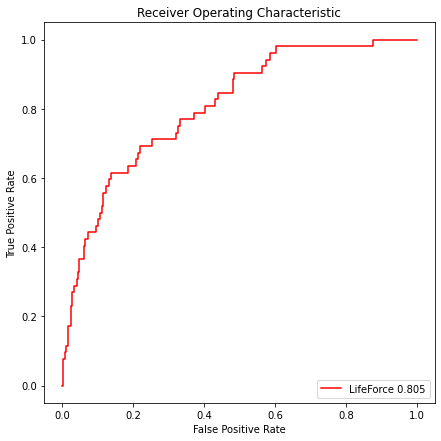

In [67]:
fpr, tpr, thresholds = roc_curve(targets, predictions)
roc_auc = auc(fpr, tpr)
# Step 5: Plot the ROC curve
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, color='r', label='LifeForce %0.3f' % roc_auc)
# Step 6: Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

# Step 7: Show the plot
plt.show()

In [79]:
model_path = 'LFmodel.pt'

torch.save(model.state_dict(), model_path)

In [80]:
model = LifeForce(40, 128)

In [81]:
model.load_state_dict(torch.load(model_path))
model.eval()

LifeForce(
  (embedding): Linear(in_features=40, out_features=128, bias=True)
  (LSTM): LSTM(128, 128, num_layers=3)
  (relu): ReLU()
  (clf): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [82]:
model

LifeForce(
  (embedding): Linear(in_features=40, out_features=128, bias=True)
  (LSTM): LSTM(128, 128, num_layers=3)
  (relu): ReLU()
  (clf): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [68]:
sofa = pd.read_csv('mews_sofa.csv')

In [72]:
sofa['LF'] = predictions

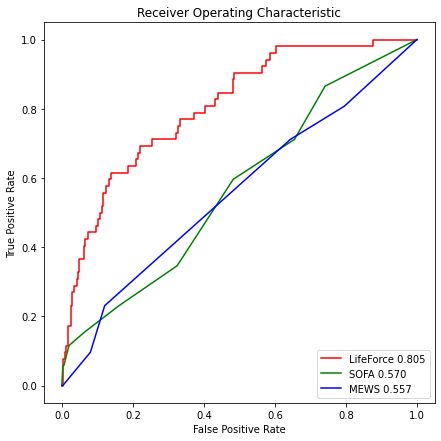

In [77]:
fpr, tpr, thresholds = roc_curve(targets, sofa['LF'])
roc_auc = auc(fpr, tpr)
# Step 5: Plot the ROC curve
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, color='r', label='LifeForce %0.3f' % roc_auc)

fpr, tpr, thresholds = roc_curve(targets, sofa['SOFA_max'])
roc_auc = auc(fpr, tpr)
# Step 5: Plot the ROC curve
plt.plot(fpr, tpr, color='g', label='SOFA %0.3f' % roc_auc)

fpr, tpr, thresholds = roc_curve(targets, sofa['mews_max'])
roc_auc = auc(fpr, tpr)
# Step 5: Plot the ROC curve
plt.plot(fpr, tpr, color='b', label='MEWS %0.3f' % roc_auc)


# Step 6: Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

# Step 7: Show the plot
plt.show()

In [83]:
sofa.to_csv('output_result.csv', index=False)